# Variational AutoEncoder in Dog Breed Identification
--- 

Challenge for the Hand Talk [selective process](https://handtalk.notion.site/VAE-Dogs-82e2c5f64d7d43d38fc586a6b20d5268).  
*author: [@baiochi](http://github.com/baiochi)*

Implementation example using `Keras`.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras

import session_info
session_info.show()

In [32]:
IMAGES_LIST = os.listdir('database/sample_train/training_class')
IMAGES_PATH = 'database/sample_train/'
BATCH_SIZE = 256
EPOCHS = 10
IMAGE_DIM = (64, 64, 3)
LATENT_DIM = (16, 16, 32)

# Load and preprocess images

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory(
	directory=IMAGES_PATH,	 # this folder contains just a subset of the training data
	target_size=(64, 64),
	batch_size=BATCH_SIZE,
	class_mode='input',
	subset='training'
)

Found 10222 images belonging to 1 classes.


# Encoder

In [4]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Create encoder layers
encoder_inputs = keras.Input(shape=IMAGE_DIM)
x = Conv2D(48, (3, 3), activation="relu", padding="same")(encoder_inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoder_outputs = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Build encoder
encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")

print(f'Encoder inputs shape: {encoder_inputs.shape}')
print(f'Encoder outputs shape: {encoder_outputs.shape}')
encoder.summary()

Encoder inputs shape: (None, 64, 64, 3)
Encoder outputs shape: (None, 16, 16, 32)
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 48)        1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 96)        41568     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 96)       0         
 2D)                                                             
                                           

# Decoder

In [5]:
# Create decoder layers
latent_inputs = keras.Input(shape=LATENT_DIM)
x = Conv2D(96, (1, 1), activation="relu", padding="same")(latent_inputs)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoder_outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Build decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

print(f'decoder inputs: {latent_inputs.shape}')
print(f'decoder outputs: {decoder_outputs.shape}')
decoder.summary()

decoder inputs: (None, 16, 16, 32)
decoder outputs: (None, 64, 64, 3)
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 32)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 96)        3168      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 96)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 96)        83040     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 64, 64, 96)       0         
 2D)                                                             
                                                       

# Variational AutoEncoder

In [6]:
# Build variational autoencoder
auto_encoder_inputs = decoder(encoder_outputs)
vae = keras.Model(encoder_inputs, auto_encoder_inputs, name="vae")
vae.compile(optimizer='Adam', loss='binary_crossentropy')
print(f'\nautoencoder inputs: {auto_encoder_inputs.shape}')
vae.summary()


autoencoder inputs: (None, 64, 64, 3)
Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 48)        1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 96)        41568     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 96)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)      

In [7]:
# Train model
history = vae.fit(
	train_batches, 
	epochs=EPOCHS,
	batch_size=BATCH_SIZE,
	verbose=10)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [8]:
# Save Model
vae.save('vae_dog_keras_v1.h5')

# Visualizing sample images

1/1 [==============================] - 0s 120ms/step


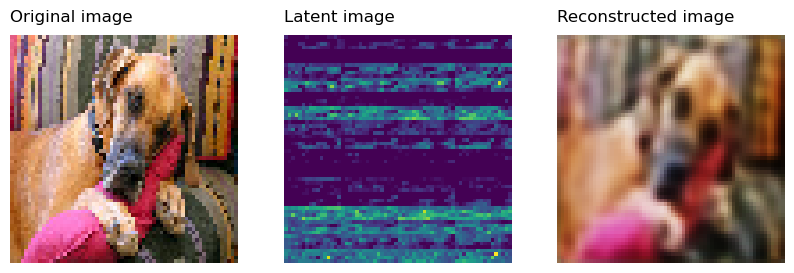

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)

# Get sample image from batch
sample_image = next(iter(train_batches))[0][0]

# Create latent image representation with encoder
latent_image = encoder.predict(sample_image.reshape(1, IMAGE_DIM[0], IMAGE_DIM[1], IMAGE_DIM[2]))

# Flatten latent image to plot
mx = np.max(latent_image[0])
mn = np.min(latent_image[0])
latent_image_flat = ((latent_image[0] - mn) * 255/(mx - mn)).flatten(order='F')
latent_image_flat = latent_image_flat[:IMAGE_DIM[0]*IMAGE_DIM[1]].reshape(IMAGE_DIM[0], IMAGE_DIM[1])

# Create reconstructed image with decoder
decoded_image = decoder.predict(latent_image).reshape(IMAGE_DIM[0], IMAGE_DIM[1], IMAGE_DIM[2])

# Plot original image
plt.title('Original image', loc='left', pad=10); plt.axis('off')
plt.imshow(sample_image);

# Plot latent image
plt.subplot(1,3,2)
plt.title('Latent image', loc='left', pad=10); plt.axis('off')
plt.imshow(latent_image_flat);

# Plot reconstructed image
plt.subplot(1,3,3)
plt.title('Reconstructed image', loc='left', pad=10); plt.axis('off')
plt.imshow(decoded_image);

1815

In [42]:
# CREATE 10000 CROPPED IMAGES
x = np.random.choice(np.arange(len(IMAGES_LIST)),10)
images = np.zeros((10000,64,64,3))
for i in range(len(x)):
    img = Image.open(IMAGES_PATH + 'training_class/'+ IMAGES_LIST[x[i]])
    img = img.resize((100,int(img.size[1]/(img.size[0]/100))), Image.ANTIALIAS)
    img = img.crop((18, 0, 82, 64))
    images[i,:,:,:] = np.asarray(img).astype('float32') / 255.
    #if i%1000==0: print(i)
        
# CALCULATE ELLIPSOID FROM 10000 IMAGES        
encoded_imgs = encoder.predict(images)
sz = LATENT_DIM[0] * LATENT_DIM[1] * LATENT_DIM[2]
encoded_imgs = encoded_imgs.reshape((-1,sz))
mm = np.mean(encoded_imgs,axis=0)
ss = np.cov(encoded_imgs,rowvar=False)

# GENERATE 9 RANDOM DOG IMAGES
generated = np.random.multivariate_normal(mm,ss,9)
generated = generated.reshape((-1,LATENT_DIM[0],LATENT_DIM[1],LATENT_DIM[2]))

/var/folders/_m/3m0bcc4n6h73gny0bt6_g4x80000gn/T/ipykernel_74403/951230046.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((100,int(img.size[1]/(img.size[0]/100))), Image.ANTIALIAS)


313/313 [==============================] - 50s 160ms/step


1/1 [==============================] - 0s 113ms/step


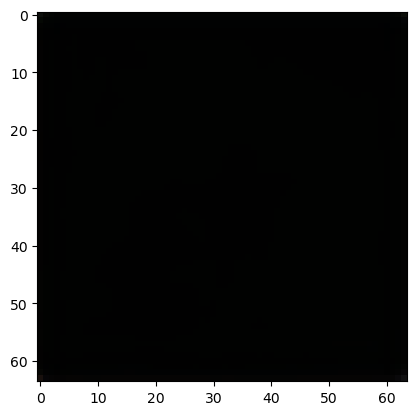

In [43]:
k = 1
decoded_image = decoder.predict(generated[k*3].reshape((-1,LATENT_DIM[0],LATENT_DIM[1],LATENT_DIM[2])))
plt.imshow(decoded_image[0])#.reshape((64,64,3))

## Sample data predictions

In [23]:
def generate_images(
	model:keras.Model, n:int, img_size:int, latent_dim:int,
	scale:float=1.0, show_fig:bool=True) -> np.ndarray:
	"""Generate and plot n images from the model(VAE), sampled by a Gaussian distribution.

	Parameters:
		model (keras.Model): The model to use for generation.
		n (int): The number of images to generate.
		img_size (int): The length of the predicted images, assuming it have a square format.
		latent_dim (int): The dimension of the latent space.
		scale (float): The scale of the latent space to sample from. Higher values will result in more noise, 
		and lower will show more similar images.
		show_fig (bool): Whether to show the figure or not.
	
	Returns:
		np.ndarray: A tensor representation of the generated images.
	"""

	# Sample from the latent space
	z = np.random.normal(size=(n, latent_dim)) * scale

	# Decode the samples
	predictions = model.predict(z)

	# Rescale the images to the original scale
	predictions = (predictions * 255).astype("uint8")

	# Plot the images
	if show_fig:
		fig = plt.figure(figsize=(10, 10))
		for i in range(n):
			ax = fig.add_subplot(10, 10, i + 1)
			plt.imshow(predictions[i, :, :, 0], cmap="gray")
			plt.axis("off")
		plt.show()

	# Return the predictions
	return predictions

In [ ]:
generate_images(vae, 6, IMAGE_DIM[0], LATENT_DIM[0], scale=1.0, show_fig=True)

## Display grid of samples

In [13]:
def generate_images_from_grid(model, n, img_size, scale=1.0, sample:str='gaussian') -> plt.figure:
	"""Generate and plot n images from the model, sampled by a Gaussian distribution.

	Parameters:
		model (keras.Model): The model to use for generation.
		n (int): The number of images to generate.
		img_size (int): The length of the predicted images, assuming it have a square format.
		scale (float): The scale of the latent space to sample from. Higher values will result in more noise, 
		and lower will show more similar images.
		sample (str): The type of sampling to use. Can be 'gaussian' or 'grid'.
	
	Returns:
		A matplotlib figure containing the generated images.
	"""

	# Linearly spaced coordinates corresponding to the 2D plot of digit classes in the latent space
	grid_x = np.linspace(-scale, scale, n)
	grid_y = np.linspace(-scale, scale, n)[::-1]
	grid_x, grid_y = np.meshgrid(grid_x, grid_y)
	grid_x = grid_x.reshape(-1, 1)
	grid_y = grid_y.reshape(-1, 1)

	# Sample from the linear latent space
	if sample=='linear':
		z = np.hstack([grid_x, grid_y])
	# Sample from the Gaussian latent space
	elif sample=='gaussian':
		z = np.random.normal(size=((n**2), 2)) * scale
	else:
		raise ValueError(f"Invalid sample type: {sample}. Select 'linear' or 'gaussian'.")

	# Generate images from the grid sample values
	predictions = vae.predict(z)
	
	#predictions = (predictions * 255).astype("uint8")

	# Configure plot
	fig = plt.figure(figsize=(12, 12))
	# Compute coordinates and labels for the plot
	start_range = img_size // 2
	end_range = (n**2) * img_size + start_range
	pixel_range = np.arange(start_range, end_range, img_size)[:n:]
	sample_range_x = np.round(grid_x, 1)[:n:].T[0]
	sample_range_y = np.round(grid_y, 1)[::n].T[0]
	plt.xticks(pixel_range, sample_range_x)
	plt.yticks(pixel_range, sample_range_y)
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")

	# Display image
	plt.imshow(
		predictions.reshape(
			n, n, img_size, img_size
			).transpose(0, 2, 1, 3
			).reshape(n*img_size, n*img_size), 
		cmap='gray')

	return fig

In [ ]:
generate_images_from_grid(vae, 6, 64, 1, 'gaussian').show()

# Discussion